# Backends

> SAX Backends

In [1]:
import jax
import jax.numpy as jnp
import klujax
import networkx as nx
import sax

## Introduction

SAX allows to easily interchange the backend of a circuit. A SAX backend consists of two static analysis steps and an evaluation step:

```{eval-rst}
.. autofunction:: sax.backends.analyze_instances
```

```{eval-rst}
.. autofunction:: sax.backends.analyze_circuit
```

```{eval-rst}
.. autofunction:: sax.backends.evaluate_circuit
```

The `analyze_instances` step analyzes the 'shape' of the instances by running each model with default parameters. By shape we mean which port-combinations are present in the sparse S-matrix.

:::{warning}
QUESTION: can we do this more efficiently in a functional way?
:::

After analyzing the instances, it is assumed that the shape of the instance won't change any more. **It is therefore important that you write your model functions in such a way that the port combinations present in your s-matrix *never* changes!**

:::{note}
we used to do this analysis step in `analyze_circuit` by just looking at the connections present. However, this inherently assumed dense connectivity within the model. This is pretty inefficient for large sparse models with many ports. Ideally, however, we should be able to analyze the shape of our instances without running their models with default parameters...
:::

The `analyze_circuit` step should statically analyze the connections and ports and should return an `analyzed` object. This object contains all the static objects that are needed for circuit computation but won't be recalculated when any parameters of the circuit change. See KLU Backend (below) for a non-trivial implementation of the circuit analyzation.

The `evaluate_circuit` step evaluates the circuit for given `SType` instances, given whatever analysis object was returned from the `analyze_circuit` step and the instance `SType`s.

## Example

In [2]:
wg_sdict: sax.SDict = {
    ("in0", "out0"): 0.5 + 0.86603j,
    ("out0", "in0"): 0.5 + 0.86603j,
}

τ, κ = 0.5**0.5, 1j * 0.5**0.5
dc_sdense: sax.SDense = (
    jnp.array([[0, 0, τ, κ], [0, 0, κ, τ], [τ, κ, 0, 0], [κ, τ, 0, 0]]),
    {"in0": 0, "in1": 1, "out0": 2, "out1": 3},
)

instances = {
    "dc1": {"component": "dc"},
    "wg": {"component": "wg"},
    "dc2": {"component": "dc"},
}
connections = {
    "dc1,out0": "wg,in0",
    "wg,out0": "dc2,in0",
    "dc1,out1": "dc2,in1",
}
ports = {
    "in0": "dc1,in0",
    "in1": "dc1,in1",
    "out0": "dc2,out0",
    "out1": "dc2,out1",
}
models = {
    "wg": lambda: wg_sdict,
    "dc": lambda: dc_sdense,
}

analyzed_instances = sax.backends.analyze_instances(instances, models)
analyzed_circuit = sax.backends.analyze_circuit(analyzed_instances, connections, ports)
mzi_sdict = sax.sdict(
    sax.backends.evaluate_circuit(
        analyzed_circuit, {k: models[v["component"]]() for k, v in instances.items()}
    )
)
mzi_sdict

{('in0', 'in0'): Array(0.+0.j, dtype=complex128),
 ('in0', 'in1'): Array(0.+0.j, dtype=complex128),
 ('in0', 'out0'): Array(-0.25+0.433015j, dtype=complex128),
 ('in0', 'out1'): Array(-0.433015+0.75j, dtype=complex128),
 ('in1', 'in0'): Array(0.+0.j, dtype=complex128),
 ('in1', 'in1'): Array(0.+0.j, dtype=complex128),
 ('in1', 'out0'): Array(-0.433015+0.75j, dtype=complex128),
 ('in1', 'out1'): Array(0.25-0.433015j, dtype=complex128),
 ('out0', 'in0'): Array(-0.25+0.433015j, dtype=complex128),
 ('out0', 'in1'): Array(-0.433015+0.75j, dtype=complex128),
 ('out0', 'out0'): Array(0.+0.j, dtype=complex128),
 ('out0', 'out1'): Array(0.+0.j, dtype=complex128),
 ('out1', 'in0'): Array(-0.433015+0.75j, dtype=complex128),
 ('out1', 'in1'): Array(0.25-0.433015j, dtype=complex128),
 ('out1', 'out0'): Array(0.+0.j, dtype=complex128),
 ('out1', 'out1'): Array(0.+0.j, dtype=complex128)}

## Filipsson-Gunnar Backend

:::{note}
Since The KLU Backend (see below) is Superior to the Filipsson-Gunnar backend, SAX will default (since v0.10.0) to the KLU backend if `klujax` is installed.name1
:::

The Filipsson-Gunnar backend is based on the following paper:

> Filipsson, Gunnar. "*A new general computer algorithm for S-matrix calculation of interconnected multiports.*" 11th European Microwave Conference. IEEE, 1981.

```{eval-rst}
.. autofunction:: sax.backends.analyze_circuit_fg
```

```{eval-rst}
.. autofunction:: sax.backends.evaluate_circuit_fg
```

### Algorithm Walkthrough

:::{note}
This algorithm gets pretty slow for large circuits. Since SAX v0.10.0 we will default to the superior KLU backend as the KLU backend is now also jittable.
:::

Let's walk through all the steps of this algorithm. We'll do this for a simple MZI circuit, given by two directional couplers characterised by `dc_sdense` with a phase shifting waveguide in between `wg_sdict`:

In [3]:
instances = {
    "dc1": dc_sdense,
    "wg": wg_sdict,
    "dc2": dc_sdense,
}
connections = {
    "dc1,out0": "wg,in0",
    "wg,out0": "dc2,in0",
    "dc1,out1": "dc2,in1",
}
ports = {
    "in0": "dc1,in0",
    "in1": "dc1,in1",
    "out0": "dc2,out0",
    "out1": "dc2,out1",
}

as a first step, we construct the `reversed_ports`, it's actually easier to work with `reversed_ports` (we chose the opposite convention in the netlist definition to adhere to the GDSFactory netlist convention):

In [4]:
reversed_ports = {v: k for k, v in ports.items()}

The first real step of the algorithm is to create the 'block diagonal sdict`:

In [5]:
block_diag = {}
for name, S in instances.items():
    block_diag.update(
        {(f"{name},{p1}", f"{name},{p2}"): v for (p1, p2), v in sax.sdict(S).items()}
    )

we can optionally filter out zeros from the resulting block_diag representation. Just note that this will make the resuling function unjittable (the resulting 'shape' (i.e. keys) of the dictionary would depend on the data itself, which is not allowed in JAX jit). We're doing it here to avoid printing zeros but **internally this is not done by default**.

In [6]:
block_diag = {k: v for k, v in block_diag.items() if jnp.abs(v) > 1e-10}
print(len(block_diag))
block_diag

18


{('dc1,in0', 'dc1,out0'): Array(0.70710678+0.j, dtype=complex128),
 ('dc1,in0', 'dc1,out1'): Array(0.+0.70710678j, dtype=complex128),
 ('dc1,in1', 'dc1,out0'): Array(0.+0.70710678j, dtype=complex128),
 ('dc1,in1', 'dc1,out1'): Array(0.70710678+0.j, dtype=complex128),
 ('dc1,out0', 'dc1,in0'): Array(0.70710678+0.j, dtype=complex128),
 ('dc1,out0', 'dc1,in1'): Array(0.+0.70710678j, dtype=complex128),
 ('dc1,out1', 'dc1,in0'): Array(0.+0.70710678j, dtype=complex128),
 ('dc1,out1', 'dc1,in1'): Array(0.70710678+0.j, dtype=complex128),
 ('wg,in0', 'wg,out0'): (0.5+0.86603j),
 ('wg,out0', 'wg,in0'): (0.5+0.86603j),
 ('dc2,in0', 'dc2,out0'): Array(0.70710678+0.j, dtype=complex128),
 ('dc2,in0', 'dc2,out1'): Array(0.+0.70710678j, dtype=complex128),
 ('dc2,in1', 'dc2,out0'): Array(0.+0.70710678j, dtype=complex128),
 ('dc2,in1', 'dc2,out1'): Array(0.70710678+0.j, dtype=complex128),
 ('dc2,out0', 'dc2,in0'): Array(0.70710678+0.j, dtype=complex128),
 ('dc2,out0', 'dc2,in1'): Array(0.+0.70710678j, d

next, we sort the connections such that similar components are grouped together:

In [7]:
from sax.backends.filipsson_gunnar import _connections_sort_key

sorted_connections = sorted(connections.items(), key=_connections_sort_key)
sorted_connections

[('dc1,out1', 'dc2,in1'), ('dc1,out0', 'wg,in0'), ('wg,out0', 'dc2,in0')]

Now we iterate over the sorted connections and connect components as they come in. Connected components take over the name of the first component in the connection, but we keep a set of components belonging to that key in `all_connected_instances`.

This is how this `all_connected_instances` dictionary looks initially.

In [8]:
all_connected_instances = {k: {k} for k in instances}
all_connected_instances

{'dc1': {'dc1'}, 'wg': {'wg'}, 'dc2': {'dc2'}}

Normally we would loop over every connection in `sorted_connections` now, but let's just go through it once at first:

In [9]:
# for k, l in sorted_connections:
k, l = sorted_connections[0]
k, l

('dc1,out1', 'dc2,in1')

`k` and `l` are the S-matrix indices we're trying to connect. Note that in our sparse `SDict` notation these S-matrix indices are in fact equivalent with the port names `('dc1,out1', 'dc2,in1')`!

first we split the connection string into an instance name and a port name (we don't use the port name yet):

In [10]:
name1, _ = k.split(",")
name2, _ = l.split(",")

We then obtain the new set of connected instances.

In [11]:
connected_instances = all_connected_instances[name1] | all_connected_instances[name2]
connected_instances

{'dc1', 'dc2'}

We then iterate over each of the components in this set and make sure each of the component names in that set maps to that set (yes, I know... confusing). We do this to be able to keep track with which components each of the components in the circuit is currently already connected to.

In [12]:
for name in connected_instances:
    all_connected_instances[name] = connected_instances

all_connected_instances

{'dc1': {'dc1', 'dc2'}, 'wg': {'wg'}, 'dc2': {'dc1', 'dc2'}}

now we need to obtain all the ports of the currently connected instances.

In [13]:
current_ports = tuple(
    p
    for instance in connected_instances
    for p in set([p for p, _ in block_diag] + [p for _, p in block_diag])
    if p.startswith(f"{instance},")
)

current_ports

('dc1,in1',
 'dc1,in0',
 'dc1,out0',
 'dc1,out1',
 'dc2,out0',
 'dc2,in0',
 'dc2,out1',
 'dc2,in1')

Now the Gunnar Algorithm is used. Given a (block-diagonal) 'S-matrix' `block_diag` and a 'connection matrix' `current_ports` we can interconnect port `k` and `l` as follows:

> Note: some creative freedom is used here. In SAX, the matrices we're talking about are in fact represented by a sparse dictionary (an `SDict`), i.e. similar to a COO sparse matrix for which the indices are the port names.

Just as before, we're filtering the zeros from the sparse representation (remember, internally this is **not done by default**).

In [14]:
block_diag = {k: v for k, v in block_diag.items() if jnp.abs(v) > 1e-10}
print(len(block_diag))
block_diag

18


{('dc1,in0', 'dc1,out0'): Array(0.70710678+0.j, dtype=complex128),
 ('dc1,in0', 'dc1,out1'): Array(0.+0.70710678j, dtype=complex128),
 ('dc1,in1', 'dc1,out0'): Array(0.+0.70710678j, dtype=complex128),
 ('dc1,in1', 'dc1,out1'): Array(0.70710678+0.j, dtype=complex128),
 ('dc1,out0', 'dc1,in0'): Array(0.70710678+0.j, dtype=complex128),
 ('dc1,out0', 'dc1,in1'): Array(0.+0.70710678j, dtype=complex128),
 ('dc1,out1', 'dc1,in0'): Array(0.+0.70710678j, dtype=complex128),
 ('dc1,out1', 'dc1,in1'): Array(0.70710678+0.j, dtype=complex128),
 ('wg,in0', 'wg,out0'): (0.5+0.86603j),
 ('wg,out0', 'wg,in0'): (0.5+0.86603j),
 ('dc2,in0', 'dc2,out0'): Array(0.70710678+0.j, dtype=complex128),
 ('dc2,in0', 'dc2,out1'): Array(0.+0.70710678j, dtype=complex128),
 ('dc2,in1', 'dc2,out0'): Array(0.+0.70710678j, dtype=complex128),
 ('dc2,in1', 'dc2,out1'): Array(0.70710678+0.j, dtype=complex128),
 ('dc2,out0', 'dc2,in0'): Array(0.70710678+0.j, dtype=complex128),
 ('dc2,out0', 'dc2,in1'): Array(0.+0.70710678j, d

This is the resulting block-diagonal matrix after interconnecting two ports (i.e. basically saying that those two ports are the same port). Because these ports are now connected we should actually remove them from the S-matrix representation (they are integrated into the S-parameters of the other connections):

In [15]:
for i, j in list(block_diag.keys()):
    is_connected = i == k or i == l or j == k or j == l
    is_in_output_ports = i in reversed_ports and j in reversed_ports
    if is_connected and not is_in_output_ports:
        del block_diag[i, j]  # we're no longer interested in these port combinations

print(len(block_diag))
block_diag

10


{('dc1,in0', 'dc1,out0'): Array(0.70710678+0.j, dtype=complex128),
 ('dc1,in1', 'dc1,out0'): Array(0.+0.70710678j, dtype=complex128),
 ('dc1,out0', 'dc1,in0'): Array(0.70710678+0.j, dtype=complex128),
 ('dc1,out0', 'dc1,in1'): Array(0.+0.70710678j, dtype=complex128),
 ('wg,in0', 'wg,out0'): (0.5+0.86603j),
 ('wg,out0', 'wg,in0'): (0.5+0.86603j),
 ('dc2,in0', 'dc2,out0'): Array(0.70710678+0.j, dtype=complex128),
 ('dc2,in0', 'dc2,out1'): Array(0.+0.70710678j, dtype=complex128),
 ('dc2,out0', 'dc2,in0'): Array(0.70710678+0.j, dtype=complex128),
 ('dc2,out1', 'dc2,in0'): Array(0.+0.70710678j, dtype=complex128)}

Note that this deletion of values **does NOT** make this operation un-jittable. The deletion depends on the ports of the dictionary (i.e. on the dictionary 'shape'), not on the values.

We now basically have to do those steps again for all other connections:

In [16]:
from sax.backends.filipsson_gunnar import _interconnect_ports

# for k, l in sorted_connections:
for k, l in sorted_connections[
    1:
]:  # we just did the first iteration of this loop above...
    name1, _ = k.split(",")
    name2, _ = l.split(",")
    connected_instances = (
        all_connected_instances[name1] | all_connected_instances[name2]
    )
    for name in connected_instances:
        all_connected_instances[name] = connected_instances
    current_ports = tuple(
        p
        for instance in connected_instances
        for p in set([p for p, _ in block_diag] + [p for _, p in block_diag])
        if p.startswith(f"{instance},")
    )
    block_diag.update(_interconnect_ports(block_diag, current_ports, k, l))
    for i, j in list(block_diag.keys()):
        is_connected = i == k or i == l or j == k or j == l
        is_in_output_ports = i in reversed_ports and j in reversed_ports
        if is_connected and not is_in_output_ports:
            del block_diag[
                i, j
            ]  # we're no longer interested in these port combinations

This is the final MZI matrix we're getting:

In [17]:
block_diag

{('dc1,in1', 'dc1,in1'): Array(0.+0.j, dtype=complex128),
 ('dc1,in1', 'dc1,in0'): Array(0.+0.j, dtype=complex128),
 ('dc1,in1', 'dc2,out0'): Array(-0.433015+0.25j, dtype=complex128),
 ('dc1,in1', 'dc2,out1'): Array(-0.25-0.433015j, dtype=complex128),
 ('dc1,in0', 'dc1,in1'): Array(0.+0.j, dtype=complex128),
 ('dc1,in0', 'dc1,in0'): Array(0.+0.j, dtype=complex128),
 ('dc1,in0', 'dc2,out0'): Array(0.25+0.433015j, dtype=complex128),
 ('dc1,in0', 'dc2,out1'): Array(-0.433015+0.25j, dtype=complex128),
 ('dc2,out0', 'dc1,in1'): Array(-0.433015+0.25j, dtype=complex128),
 ('dc2,out0', 'dc1,in0'): Array(0.25+0.433015j, dtype=complex128),
 ('dc2,out0', 'dc2,out0'): Array(0.+0.j, dtype=complex128),
 ('dc2,out0', 'dc2,out1'): Array(0.+0.j, dtype=complex128),
 ('dc2,out1', 'dc1,in1'): Array(-0.25-0.433015j, dtype=complex128),
 ('dc2,out1', 'dc1,in0'): Array(-0.433015+0.25j, dtype=complex128),
 ('dc2,out1', 'dc2,out0'): Array(0.+0.j, dtype=complex128),
 ('dc2,out1', 'dc2,out1'): Array(0.+0.j, dtype

All that's left is to rename these internal ports of the format `{instance},{port}` into output ports of the resulting circuit:

In [18]:
circuit_sdict: sax.SDict = {
    (reversed_ports[i], reversed_ports[j]): v
    for (i, j), v in block_diag.items()
    if i in reversed_ports and j in reversed_ports
}
circuit_sdict

{('in1', 'in1'): Array(0.+0.j, dtype=complex128),
 ('in1', 'in0'): Array(0.+0.j, dtype=complex128),
 ('in1', 'out0'): Array(-0.433015+0.25j, dtype=complex128),
 ('in1', 'out1'): Array(-0.25-0.433015j, dtype=complex128),
 ('in0', 'in1'): Array(0.+0.j, dtype=complex128),
 ('in0', 'in0'): Array(0.+0.j, dtype=complex128),
 ('in0', 'out0'): Array(0.25+0.433015j, dtype=complex128),
 ('in0', 'out1'): Array(-0.433015+0.25j, dtype=complex128),
 ('out0', 'in1'): Array(-0.433015+0.25j, dtype=complex128),
 ('out0', 'in0'): Array(0.25+0.433015j, dtype=complex128),
 ('out0', 'out0'): Array(0.+0.j, dtype=complex128),
 ('out0', 'out1'): Array(0.+0.j, dtype=complex128),
 ('out1', 'in1'): Array(-0.25-0.433015j, dtype=complex128),
 ('out1', 'in0'): Array(-0.433015+0.25j, dtype=complex128),
 ('out1', 'out0'): Array(0.+0.j, dtype=complex128),
 ('out1', 'out1'): Array(0.+0.j, dtype=complex128)}

And that's it. We evaluated the `SDict` of the full circuit.

### Algorithm Improvements

The Filipsson-Gunar algorithm is 

* pretty fast for small circuits 🙂
* jittable 🙂
* differentiable 🙂
* GPU-compatible 🙂

This algorithm is however:

* **really slow** for large circuits 😥
* **pretty slow** to jit the resulting circuit function 😥
* **pretty slow** to differentiate the resulting circuit function 😥

There are probably still plenty of improvements possible for this algorithm:

* **¿** Network analysis (ft. NetworkX ?) to obtain which ports of the block diagonal representation are relevant to obtain the output connection **?**
* **¿** Smarter ordering of connections to always have the minimum amount of ports in the intermediate block-diagonal representation **?**
* **¿** Using `jax.lax.scan` in stead of python native for-loops in `_interconnect_ports` **?**
* **¿** ... **?**

Bottom line is... Do you know how to improve this algorithm or how to implement the above suggestions? Please open a Merge Request!

## KLU Backend

The KLU backend is using `klujax`, which uses the [SuiteSparse](https://github.com/DrTimothyAldenDavis/SuiteSparse) C++ libraries for sparse matrix evaluations to evaluate the circuit insanely fast on a CPU. The specific algorith being used in question is the KLU algorithm:

> Ekanathan Palamadai Natariajan. "*KLU - A high performance sparse linear solver for circuit simulation problems.*"

```{eval-rst}
.. autofunction:: sax.backends.analyze_circuit_klu
```

```{eval-rst}
.. autofunction:: sax.backends.evaluate_circuit_klu
```

### Theoretical Background

The core of the KLU algorithm is supported by `klujax`, which internally uses the Suitesparse libraries to solve the sparse system `Ax = b`, in which A is a sparse matrix.

Now it only comes down to shoehorn our circuit evaluation into a sparse linear system of equations $Ax=b$ where we need to solve for $x$ using `klujax`. 
Consider the block diagonal matrix $S_{bd}$ of all components in the circuit acting on the fields $x_{in}$ at each of the individual ports of each of the component integrated in $S^{bd}$. The output fields $x^{out}$ at each of those ports is then given by:

$$
x^{out} = S_{bd} x^{in}
$$

However, $S_{bd}$ is not the S-matrix of the circuit as it does not encode any connectivity *between* the components. Connecting two component ports basically comes down to enforcing equality between the output fields at one port of a component with the input fields at another port of another (or maybe even the same) component. This equality can be enforced by creating an internal connection matrix, connecting all internal ports of the circuit:

$$
x^{in} = C_{int} x^{out}
$$

We can thus write the following combined equation:

$$
x^{in} = C_{int} S_{bd} x^{in}
$$

But this is not the complete story... Some component ports will *not* be *interconnected* with other ports: they will become the new *external ports* (or output ports) of the combined circuit. We can include those external ports into the above equation as follows:

$$
\begin{pmatrix} x^{in} \\ x^{out}_{ext} \end{pmatrix} = \begin{pmatrix} C_{int} & C_{ext} \\ C_{ext}^T & 0 \end{pmatrix} \begin{pmatrix} S_{bd} x^{in} \\ x_{ext}^{in} \end{pmatrix} 
$$

Note that $C_{ext}$ is obviously **not** a square matrix. Eliminating $x^{in}$ from the equation above finally yields:

$$
x^{out}_{ext} = C^T_{ext} S_{bd} (I - C_{int}S_{bd})^{-1} C_{ext}x_{ext}^{in}
$$

We basically found a representation of the circuit S-matrix:

$$
S = C^T_{ext} S_{bd} (I - C_{int}S_{bd})^{-1} C_{ext}
$$

Obviously, we won't want to calculate the inverse $(I - C_{int}S_{bd})^{-1}$, which is the inverse of a very sparse matrix (a connection matrix only has a single 1 per line), which very often is not even sparse itself. In stead we'll use the `solve_klu` function:

$$
S = C^T_{ext} S_{bd} \texttt{solve}\_\texttt{klu}\left((I - C_{int}S_{bd}), C_{ext}\right)
$$

Moreover, $C_{ext}^TS_{bd}$ is also a sparse matrix, therefore we'll also need a `mul_coo` routine:

$$
S = C^T_{ext} \texttt{mul}\_\texttt{coo}\left(S_{bd},~~\texttt{solve}\_\texttt{klu}\left((I - C_{int}S_{bd}),~C_{ext}\right)\right)
$$

### Sparse Helper Functions

```{eval-rst}
.. autofunction:: klujax.solve
```

```{eval-rst}
.. autofunction:: klujax.coo_mul_vec
```

`klujax.solve` solves the sparse system of equations `Ax=b` for `x`. Where `A` is represented by in [COO-format](https://en.wikipedia.org/wiki/Sparse_matrix#Coordinate_list_(COO)) as (`Ai`, `Aj`, `Ax`).

> Example

In [19]:
Ai = jnp.array([0, 1, 2, 3, 4])
Aj = jnp.array([1, 3, 4, 0, 2])
Ax = jnp.array([5, 6, 1, 1, 2])
b = jnp.array([5, 3, 2, 6, 1])
x = klujax.solve(Ai, Aj, Ax, b)
x

Array([6. , 1. , 0.5, 0.5, 2. ], dtype=float64)

This result is indeed correct:

In [20]:
A = jnp.zeros((5, 5)).at[Ai, Aj].set(Ax)
print(A)
print(A @ x)

[[0. 5. 0. 0. 0.]
 [0. 0. 0. 6. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 2. 0. 0.]]
[5. 3. 2. 6. 1.]


However, to use this function effectively, we probably need an extra dimension for `Ax`. Indeed, we would like to solve this equation for multiple wavelengths (or more general, for multiple circuit configurations) at once. For this we can use `jax.vmap` to expose `klujax.solve` to more dimensions for `Ax`:

In [21]:
solve_klu = jax.vmap(klujax.solve, (None, None, 0, None), 0)

Let's now redefine `Ax` and see what it gives:

In [22]:
Ai = jnp.array([0, 1, 2, 3, 4])
Aj = jnp.array([1, 3, 4, 0, 2])
Ax = jnp.array([[5, 6, 1, 1, 2], [5, 4, 3, 2, 1], [1, 2, 3, 4, 5]])
b = jnp.array([5, 3, 2, 6, 1])
x = solve_klu(Ai, Aj, Ax, b)
x

Array([[6.        , 1.        , 0.5       , 0.5       , 2.        ],
       [3.        , 1.        , 1.        , 0.75      , 0.66666667],
       [1.5       , 5.        , 0.2       , 1.5       , 0.66666667]],      dtype=float64)

This result is indeed correct:

In [23]:
A = jnp.zeros((3, 5, 5)).at[:, Ai, Aj].set(Ax)
jnp.einsum("ijk,ik->ij", A, x)

Array([[5., 3., 2., 6., 1.],
       [5., 3., 2., 6., 1.],
       [5., 3., 2., 6., 1.]], dtype=float64)

Additionally, we need a way to multiply a sparse COO-matrix with a dense vector. This can be done with `klujax.coo_mul_vec`:

However, it's useful to allow a batch dimension, this time *both* in `Ax` and in `b`:

In [24]:
mul_coo = None
mul_coo = jax.vmap(klujax.coo_mul_vec, (None, None, 0, 0), 0)

Let's confirm this does the right thing:

In [25]:
result = mul_coo(Ai, Aj, Ax, x)
result

Array([[5., 3., 2., 6., 1.],
       [5., 3., 2., 6., 1.],
       [5., 3., 2., 6., 1.]], dtype=float64)

### Example

In [26]:
wg_sdict: sax.SDict = {
    ("in0", "out0"): 0.5 + 0.86603j,
    ("out0", "in0"): 0.5 + 0.86603j,
}

τ, κ = 0.5**0.5, 1j * 0.5**0.5
dc_sdense: sax.SDense = (
    jnp.array([[0, 0, τ, κ], [0, 0, κ, τ], [τ, κ, 0, 0], [κ, τ, 0, 0]]),
    {"out0": 0, "out1": 1, "in0": 2, "in1": 3},
)

instances = {
    "dc1": {"component": "dc"},
    "wg": {"component": "wg"},
    "dc2": {"component": "dc"},
}
connections = {
    "dc1,out0": "wg,in0",
    "wg,out0": "dc2,in0",
    "dc1,out1": "dc2,in1",
}
ports = {
    "in0": "dc1,in0",
    "in1": "dc1,in1",
    "out0": "dc2,out0",
    "out1": "dc2,out1",
}
models = {
    "wg": lambda: wg_sdict,
    "dc": lambda: dc_sdense,
}


analyzed_instances = sax.backends.analyze_instances_klu(instances, models)
analyzed_circuit = sax.backends.analyze_circuit_klu(
    analyzed_instances, connections, ports
)
S, pm = sax.backends.evaluate_circuit_klu(
    analyzed_circuit, {k: models[v["component"]]() for k, v in instances.items()}
)

print(S)
print(pm)

[[ 0.      +0.j        0.      +0.j       -0.25    +0.433015j
  -0.433015+0.75j    ]
 [ 0.      +0.j        0.      +0.j       -0.433015+0.75j
   0.25    -0.433015j]
 [-0.25    +0.433015j -0.433015+0.75j      0.      +0.j
   0.      +0.j      ]
 [-0.433015+0.75j      0.25    -0.433015j  0.      +0.j
   0.      +0.j      ]]
{'in0': 0, 'in1': 1, 'out0': 2, 'out1': 3}


the KLU backend yields `SDense` results by default:

In [27]:
mzi_sdense = (S, pm)
mzi_sdense

(Array([[ 0.      +0.j      ,  0.      +0.j      , -0.25    +0.433015j,
         -0.433015+0.75j    ],
        [ 0.      +0.j      ,  0.      +0.j      , -0.433015+0.75j    ,
          0.25    -0.433015j],
        [-0.25    +0.433015j, -0.433015+0.75j    ,  0.      +0.j      ,
          0.      +0.j      ],
        [-0.433015+0.75j    ,  0.25    -0.433015j,  0.      +0.j      ,
          0.      +0.j      ]], dtype=complex128),
 {'in0': 0, 'in1': 1, 'out0': 2, 'out1': 3})

An `SDense` is returned for perfomance reasons. By returning an `SDense` by default we prevent any internal `SDict -> SDense` conversions in deeply hierarchical circuits. It's however very easy to convert `SDense` to `SDict` as a final step. To do this, wrap the result (or the function generating the result) with `sdict`:

In [28]:
sax.sdict(mzi_sdense)

{('in0', 'in0'): Array(0.+0.j, dtype=complex128),
 ('in0', 'in1'): Array(0.+0.j, dtype=complex128),
 ('in0', 'out0'): Array(-0.25+0.433015j, dtype=complex128),
 ('in0', 'out1'): Array(-0.433015+0.75j, dtype=complex128),
 ('in1', 'in0'): Array(0.+0.j, dtype=complex128),
 ('in1', 'in1'): Array(0.+0.j, dtype=complex128),
 ('in1', 'out0'): Array(-0.433015+0.75j, dtype=complex128),
 ('in1', 'out1'): Array(0.25-0.433015j, dtype=complex128),
 ('out0', 'in0'): Array(-0.25+0.433015j, dtype=complex128),
 ('out0', 'in1'): Array(-0.433015+0.75j, dtype=complex128),
 ('out0', 'out0'): Array(0.+0.j, dtype=complex128),
 ('out0', 'out1'): Array(0.+0.j, dtype=complex128),
 ('out1', 'in0'): Array(-0.433015+0.75j, dtype=complex128),
 ('out1', 'in1'): Array(0.25-0.433015j, dtype=complex128),
 ('out1', 'out0'): Array(0.+0.j, dtype=complex128),
 ('out1', 'out1'): Array(0.+0.j, dtype=complex128)}

### Algorithm Walkthrough

Let's first enforce $C^T = C$:

In [29]:
connections = {**connections, **{v: k for k, v in connections.items()}}
connections

{'dc1,out0': 'wg,in0',
 'wg,out0': 'dc2,in0',
 'dc1,out1': 'dc2,in1',
 'wg,in0': 'dc1,out0',
 'dc2,in0': 'wg,out0',
 'dc2,in1': 'dc1,out1'}

We'll also need the reversed ports:

In [30]:
inverse_ports = {v: k for k, v in ports.items()}
inverse_ports

{'dc1,in0': 'in0', 'dc1,in1': 'in1', 'dc2,out0': 'out0', 'dc2,out1': 'out1'}

An the port indices

In [31]:
port_map = {k: i for i, k in enumerate(ports)}
port_map

{'in0': 0, 'in1': 1, 'out0': 2, 'out1': 3}

Let's now create the COO-representation of our block diagonal S-matrix $S_{bd}$:

In [32]:
idx, Si, Sj, Sx, instance_ports = 0, [], [], [], {}
batch_shape = ()
for name, instance in instances.items():
    s = models[instance["component"]]()
    si, sj, sx, ports_map = sax.scoo(s)
    Si.append(si + idx)
    Sj.append(sj + idx)
    Sx.append(sx)
    if len(sx.shape[:-1]) > len(batch_shape):
        batch_shape = sx.shape[:-1]
    instance_ports.update({f"{name},{p}": i + idx for p, i in ports_map.items()})
    idx += len(ports_map)
Si = jnp.concatenate(Si, -1)
Sj = jnp.concatenate(Sj, -1)
Sx = jnp.concatenate(
    [jnp.broadcast_to(sx, (*batch_shape, sx.shape[-1])) for sx in Sx], -1
)

print(Si)
print(Sj)
print(Sx)

[0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3 4 5 6 6 6 6 7 7 7 7 8 8 8 8 9 9 9 9]
[0 1 2 3 0 1 2 3 0 1 2 3 0 1 2 3 5 4 6 7 8 9 6 7 8 9 6 7 8 9 6 7 8 9]
[0.        +0.j         0.        +0.j         0.70710678+0.j
 0.        +0.70710678j 0.        +0.j         0.        +0.j
 0.        +0.70710678j 0.70710678+0.j         0.70710678+0.j
 0.        +0.70710678j 0.        +0.j         0.        +0.j
 0.        +0.70710678j 0.70710678+0.j         0.        +0.j
 0.        +0.j         0.5       +0.86603j    0.5       +0.86603j
 0.        +0.j         0.        +0.j         0.70710678+0.j
 0.        +0.70710678j 0.        +0.j         0.        +0.j
 0.        +0.70710678j 0.70710678+0.j         0.70710678+0.j
 0.        +0.70710678j 0.        +0.j         0.        +0.j
 0.        +0.70710678j 0.70710678+0.j         0.        +0.j
 0.        +0.j        ]


note that we also kept track of the `batch_shape`, i.e. the number of independent simulations (usually number of wavelengths). In the example being used here we don't have a batch dimension (all elements of the `SDict` are `0D`):

In [33]:
batch_shape

()

We'll also keep track of the number of columns

In [34]:
n_col = idx
n_col

10

And we'll need to solve the circuit for each output port, i.e. we need to solve `n_rhs` number of equations:

In [35]:
n_rhs = len(port_map)
n_rhs

4

We can represent the internal connection matrix $C_{int}$ as a mapping between port indices:

In [36]:
Cmap = {int(instance_ports[k]): int(instance_ports[v]) for k, v in connections.items()}
Cmap

{0: 4, 5: 8, 1: 9, 4: 0, 8: 5, 9: 1}

Therefore, the COO-representation of this connection matrix can be obtained as follows (note that an array of values Cx is not necessary, all non-zero elements in a connection matrix are 1)

In [37]:
Ci = jnp.array(list(Cmap.keys()), dtype=jnp.int32)
Cj = jnp.array(list(Cmap.values()), dtype=jnp.int32)
print(Ci)
print(Cj)

[0 5 1 4 8 9]
[4 8 9 0 5 1]


We can represent the external connection matrix $C_{ext}$ as a map between internal port indices and external port indices:

In [38]:
Cextmap = {int(instance_ports[k]): int(port_map[v]) for k, v in inverse_ports.items()}
Cextmap

{2: 0, 3: 1, 6: 2, 7: 3}

Just as for the internal matrix we can represent this external connection matrix in COO-format:

In [39]:
Cexti = jnp.stack(list(Cextmap.keys()), 0)
Cextj = jnp.stack(list(Cextmap.values()), 0)
print(Cexti)
print(Cextj)

[2 3 6 7]
[0 1 2 3]


However, we actually need it as a dense representation:

> help needed: can we find a way later on to keep this sparse?

In [40]:
Cext = jnp.zeros((n_col, n_rhs), dtype=complex).at[Cexti, Cextj].set(1.0)
Cext

Array([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]], dtype=complex128)

We'll now calculate the row index `CSi` of $C_{int}S_{bd}$ in COO-format:

In [41]:
# TODO: make this block jittable...
Ix = jnp.ones((*batch_shape, n_col))
Ii = Ij = jnp.arange(n_col)
mask = Cj[None, :] == Si[:, None]
CSi = jnp.broadcast_to(Ci[None, :], mask.shape)[mask]
CSi

Array([4, 4, 4, 4, 9, 9, 9, 9, 0, 8, 5, 5, 5, 5, 1, 1, 1, 1], dtype=int32)

> `CSi`: possible jittable alternative? how do we remove the zeros?

In [42]:
CSi_ = jnp.where(Cj[None, :] == Si[:, None], Ci[None, :], 0).sum(1)  # not used
CSi_  # not used

Array([4, 4, 4, 4, 9, 9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0,
       0, 0, 0, 0, 5, 5, 5, 5, 1, 1, 1, 1], dtype=int64)

The column index `CSj` of $C_{int}S_{bd}$ can more easily be obtained:

In [43]:
mask = (Cj[:, None] == Si[None, :]).any(0)
CSj = Sj[mask]
CSj

Array([0, 1, 2, 3, 0, 1, 2, 3, 5, 4, 6, 7, 8, 9, 6, 7, 8, 9], dtype=int64)

Finally, the values `CSx` of $C_{int}S_{bd}$ can be obtained as follows:

In [44]:
CSx = Sx[..., mask]
CSx

Array([0.        +0.j        , 0.        +0.j        ,
       0.70710678+0.j        , 0.        +0.70710678j,
       0.        +0.j        , 0.        +0.j        ,
       0.        +0.70710678j, 0.70710678+0.j        ,
       0.5       +0.86603j   , 0.5       +0.86603j   ,
       0.70710678+0.j        , 0.        +0.70710678j,
       0.        +0.j        , 0.        +0.j        ,
       0.        +0.70710678j, 0.70710678+0.j        ,
       0.        +0.j        , 0.        +0.j        ], dtype=complex128)

Now we calculate $I - C_{int}S_{bd}$ in an *uncoalesced* way (we might have duplicate indices on the diagonal):

> **uncoalesced**: having duplicate index combinations (i, j) in the representation possibly with different corresponding values. This is usually not a problem as in linear operations these values will end up to be summed, usually the behavior you want:

In [45]:
I_CSi = jnp.concatenate([CSi, Ii], -1)
I_CSj = jnp.concatenate([CSj, Ij], -1)
I_CSx = jnp.concatenate([-CSx, Ix], -1)
print(I_CSi)
print(I_CSj)
print(I_CSx)

[4 4 4 4 9 9 9 9 0 8 5 5 5 5 1 1 1 1 0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 0 1 2 3 5 4 6 7 8 9 6 7 8 9 0 1 2 3 4 5 6 7 8 9]
[-0.        -0.j         -0.        -0.j         -0.70710678-0.j
 -0.        -0.70710678j -0.        -0.j         -0.        -0.j
 -0.        -0.70710678j -0.70710678-0.j         -0.5       -0.86603j
 -0.5       -0.86603j    -0.70710678-0.j         -0.        -0.70710678j
 -0.        -0.j         -0.        -0.j         -0.        -0.70710678j
 -0.70710678-0.j         -0.        -0.j         -0.        -0.j
  1.        +0.j          1.        +0.j          1.        +0.j
  1.        +0.j          1.        +0.j          1.        +0.j
  1.        +0.j          1.        +0.j          1.        +0.j
  1.        +0.j        ]


In [46]:
n_col, n_rhs = Cext.shape
print(n_col, n_rhs)

10 4


The batch shape dimension can generally speaking be anything (in the example here 0D). We need to do the necessary reshapings to make the batch shape 1D:

In [47]:
n_lhs = jnp.prod(jnp.array(batch_shape, dtype=jnp.int32))
print(n_lhs)

1


In [48]:
Sx = Sx.reshape(n_lhs, -1)
Sx.shape

(1, 34)

In [49]:
I_CSx = I_CSx.reshape(n_lhs, -1)
I_CSx.shape

(1, 28)

We're finally ready to do the most important part of the calculation, which we conveniently leave to `klujax` and `SuiteSparse`:

In [50]:
inv_I_CS_Cext = solve_klu(I_CSi, I_CSj, I_CSx, Cext)

one more sparse multiplication:

In [51]:
S_inv_I_CS_Cext = mul_coo(Si, Sj, Sx, inv_I_CS_Cext)

And one more $C_{ext}$ multiplication which we do by clever indexing:

In [52]:
CextT_S_inv_I_CS_Cext = S_inv_I_CS_Cext[..., Cexti, :][..., :, Cextj]
CextT_S_inv_I_CS_Cext

Array([[[ 0.      +0.j      ,  0.      +0.j      , -0.25    +0.433015j,
         -0.433015+0.75j    ],
        [ 0.      +0.j      ,  0.      +0.j      , -0.433015+0.75j    ,
          0.25    -0.433015j],
        [-0.25    +0.433015j, -0.433015+0.75j    ,  0.      +0.j      ,
          0.      +0.j      ],
        [-0.433015+0.75j    ,  0.25    -0.433015j,  0.      +0.j      ,
          0.      +0.j      ]]], dtype=complex128)

That's it! We found the S-matrix of the circuit. We just need to reshape the batch dimension back into the matrix:

In [53]:
_, n, _ = CextT_S_inv_I_CS_Cext.shape
S = CextT_S_inv_I_CS_Cext.reshape(*batch_shape, n, n)
S

Array([[ 0.      +0.j      ,  0.      +0.j      , -0.25    +0.433015j,
        -0.433015+0.75j    ],
       [ 0.      +0.j      ,  0.      +0.j      , -0.433015+0.75j    ,
         0.25    -0.433015j],
       [-0.25    +0.433015j, -0.433015+0.75j    ,  0.      +0.j      ,
         0.      +0.j      ],
       [-0.433015+0.75j    ,  0.25    -0.433015j,  0.      +0.j      ,
         0.      +0.j      ]], dtype=complex128)

Oh and to complete the `SDense` representation we need to specify the port map as well:

In [54]:
port_map

{'in0': 0, 'in1': 1, 'out0': 2, 'out1': 3}

### Algorithm Improvements

This algorithm is 

* very fast for large circuits 🙂
* jittable 🙂
* differentiable 🙂

This algorithm is however:

* **not** GPU-compatible 🙂

There are probably still plenty of improvements possible for this algorithm:

* **¿** make it GPU compatible (requires making suitesparse GPU compatible... probably not gonna happen)**?**


:::{note}
Since The KLU Backend is Superior to the Filipsson-Gunnar backend, SAX will default (since v0.10.0) to the KLU backend if `klujax` is installed.name1
:::

## Additive Backend

```{eval-rst}
.. autofunction:: sax.backends.analyze_circuit_additive
```

```{eval-rst}
.. autofunction:: sax.backends.evaluate_circuit_additive
```

Sometimes we would like to calculate circuit path lengths or time delays within a circuit. We could obviously simulate these things with a time domain simulator, but in many cases a simple additive backend (as opposed to the default multiplicative backend) can suffice.

### Example

:::{note}
in stead of S-parameters the stypes need to contain *additive* parameters, such as length or time delay.
:::

In [56]:
wg_sdict = {
    ("in0", "out0"): jnp.array(
        [100.0, 200.0, 300.0]
    ),  # assume for now there are three possible paths between these two ports.
    ("out0", "in0"): jnp.array(
        [100.0, 200.0, 300.0]
    ),  # assume for now there are three possible paths between these two ports.
}

dc_sdict = {
    ("in0", "out0"): jnp.array(
        [10.0, 20.0]
    ),  # assume for now there are two possible paths between these two ports.
    ("in0", "out1"): 15.0,
    ("in1", "out0"): 15.0,
    ("in1", "out1"): jnp.array(
        [10.0, 20.0]
    ),  # assume for now there are two possible paths between these two ports.
}

instances = {
    "dc1": {"component": "dc"},
    "wg": {"component": "wg"},
    "dc2": {"component": "dc"},
}
connections = {
    "dc1,out0": "wg,in0",
    "wg,out0": "dc2,in0",
    "dc1,out1": "dc2,in1",
}
ports = {
    "in0": "dc1,in0",
    "in1": "dc1,in1",
    "out0": "dc2,out0",
    "out1": "dc2,out1",
}
models = {
    "wg": lambda: wg_sdict,
    "dc": lambda: dc_sdense,
}

:::{note}
it is recommended to **not** use an `SDense` representation for the additive backend. Very often an `SDense` representation will introduce **zeros** which will be interpreted as an **existing connection with zero length**. Conversely, in a sparse representation like `SDict` or `SCoo`, non-existing elements will be just that: they will not be present in the internal graph.
:::

In [57]:
edges = sax.backends.additive._graph_edges(
    {k: models[v["component"]]() for k, v in instances.items()}, connections, ports
)
edges

/opt/conda/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:3078: ComplexWarning: Casting complex values to real discards the imaginary part
  out_array: Array = lax_internal._convert_element_type(


[(('dc1', 'out0'),
  ('wg', 'in0'),
  {'type': 'C', 'length': Array([0.], dtype=float64)}),
 (('wg', 'out0'),
  ('dc2', 'in0'),
  {'type': 'C', 'length': Array([0.], dtype=float64)}),
 (('dc1', 'out1'),
  ('dc2', 'in1'),
  {'type': 'C', 'length': Array([0.], dtype=float64)}),
 (('wg', 'in0'),
  ('dc1', 'out0'),
  {'type': 'C', 'length': Array([0.], dtype=float64)}),
 (('dc2', 'in0'),
  ('wg', 'out0'),
  {'type': 'C', 'length': Array([0.], dtype=float64)}),
 (('dc2', 'in1'),
  ('dc1', 'out1'),
  {'type': 'C', 'length': Array([0.], dtype=float64)}),
 (('', 'in0'),
  ('dc1', 'in0'),
  {'type': 'C', 'length': Array([0.], dtype=float64)}),
 (('', 'in1'),
  ('dc1', 'in1'),
  {'type': 'C', 'length': Array([0.], dtype=float64)}),
 (('', 'out0'),
  ('dc2', 'out0'),
  {'type': 'C', 'length': Array([0.], dtype=float64)}),
 (('', 'out1'),
  ('dc2', 'out1'),
  {'type': 'C', 'length': Array([0.], dtype=float64)}),
 (('dc1', 'in0'),
  ('', 'in0'),
  {'type': 'C', 'length': Array([0.], dtype=float64)}

We made a difference here between edges of 'S'-type (connections through the S-matrix) and edges of 'C'-type (connections through the connection matrix). Connections of 'C'-type obviously always have length zero as they signify per definition the equality of two ports.

We can create a NetworkX graph from these edges:

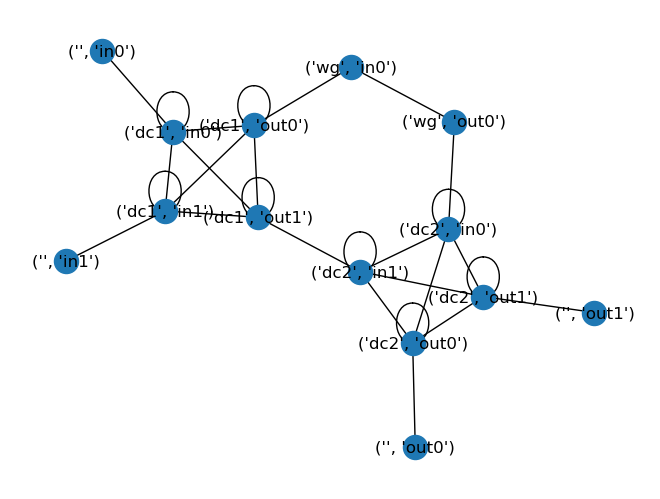

In [58]:
graph = nx.Graph()
graph.add_edges_from(edges)
nx.draw_kamada_kawai(graph, with_labels=True)

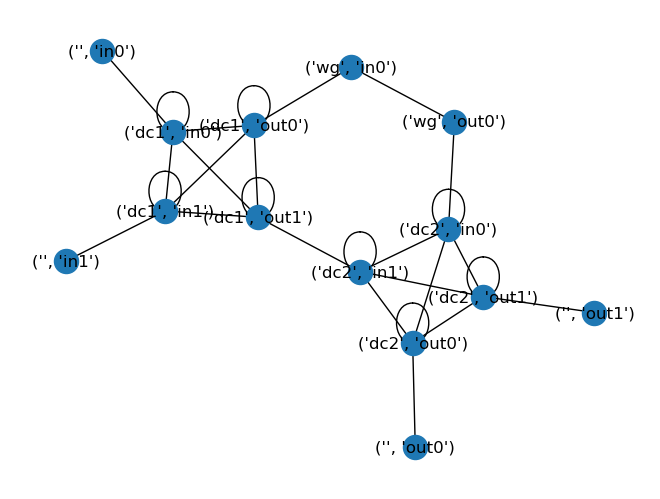

In [59]:
graph = sax.backends.additive._prune_internal_output_nodes(graph)
nx.draw_kamada_kawai(graph, with_labels=True)

We can now get a list of all possible paths in the network. Note that these paths **must** alternate between an S-edge and a C-edge:

In [60]:
paths = sax.backends.additive._get_possible_paths(graph, ("", "in0"), ("", "out0"))
paths

[[(('', 'in0'), ('dc1', 'in0')),
  (('dc1', 'in0'), ('dc1', 'out0')),
  (('dc1', 'out0'), ('wg', 'in0')),
  (('wg', 'in0'), ('wg', 'out0')),
  (('wg', 'out0'), ('dc2', 'in0')),
  (('dc2', 'in0'), ('dc2', 'out0')),
  (('dc2', 'out0'), ('', 'out0'))],
 [(('', 'in0'), ('dc1', 'in0')),
  (('dc1', 'in0'), ('dc1', 'out1')),
  (('dc1', 'out1'), ('dc2', 'in1')),
  (('dc2', 'in1'), ('dc2', 'out0')),
  (('dc2', 'out0'), ('', 'out0'))]]

And the path lengths of those paths can be calculated as follows:

In [61]:
sax.backends.additive._path_lengths(graph, paths)

[Array([101.41421356, 201.41421356, 301.41421356], dtype=float64),
 Array([0.], dtype=float64)]

This is all brought together in the additive KLU backend:

In [62]:
analyzed_instances = sax.backends.analyze_instances_additive(instances, models)
analyzed_circuit = sax.backends.analyze_circuit_additive(
    analyzed_instances, connections, ports
)
sax.backends.evaluate_circuit_additive(
    analyzed_circuit, {k: models[v["component"]]() for k, v in instances.items()}
)

/opt/conda/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:3078: ComplexWarning: Casting complex values to real discards the imaginary part
  out_array: Array = lax_internal._convert_element_type(


{('in0', 'in0'): [Array([0.], dtype=float64)],
 ('in0',
  'in1'): [Array([101.41421356, 201.41421356, 301.41421356], dtype=float64), Array([100., 200., 300.], dtype=float64), Array([0.], dtype=float64)],
 ('in0',
  'out0'): [Array([101.41421356, 201.41421356, 301.41421356], dtype=float64), Array([0.], dtype=float64)],
 ('in0',
  'out1'): [Array([100.70710678, 200.70710678, 300.70710678], dtype=float64), Array([0.70710678], dtype=float64)],
 ('in1', 'in0'): [Array([100., 200., 300.], dtype=float64),
  Array([101.41421356, 201.41421356, 301.41421356], dtype=float64),
  Array([0.], dtype=float64)],
 ('in1', 'in1'): [Array([0.], dtype=float64)],
 ('in1',
  'out0'): [Array([100.70710678, 200.70710678, 300.70710678], dtype=float64), Array([0.70710678], dtype=float64)],
 ('in1', 'out1'): [Array([100., 200., 300.], dtype=float64),
  Array([1.41421356], dtype=float64)],
 ('out0',
  'in0'): [Array([101.41421356, 201.41421356, 301.41421356], dtype=float64), Array([0.], dtype=float64)],
 ('out0',
